In [67]:
import numpy as np
import torch
from models import get_model_from_exp
from utils import get_args
latents_dims = np.array([10,10,10,8,4,15,1])
latents_bases = torch.tensor(np.concatenate((latents_dims[::-1].cumprod()[::-1][1:],
                                np.array([1,]))))[:-1]
latent_dims = torch.tensor(latents_dims)

def index_to_latent(index):
    latents = []
    for base in latents_bases:
        latents.append(index // base)
        index = index % base
    return np.array(latents)

def latent_to_index(latents):
    return torch.matmul(latents, latents_bases.T.float())

def generate_valid_deltas(base_latent, idx, max_delta=15):
    base_val = int(base_latent[idx])  # ensure it's an integer
    deltas = []

    for d in range(1, max_delta + 1):
        for sign in [-1, 1]:
            new_val = base_val + sign * d
            if 0 <= new_val < latent_dims[idx]:
                delta = torch.zeros(6)
                delta[idx] = sign * d
                deltas.append(delta)

    return torch.stack(deltas) if deltas else torch.zeros(0, 6)

class DeltaDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, latents, reps=None, idx=0):
        self.latents = latents
        self.imgs = imgs if reps is None else reps
        self.idx = idx
        self.use_reps = reps is not None
  
    def __len__(self):
        return len(self.latents)

    def __getitem__(self, index):
        img = self.imgs[index]
        img_shape = img.shape
        img = img.unsqueeze(0)
        latent = self.latents[index]
        deltas = generate_valid_deltas(latent, self.idx)
        mod_latents = latent + deltas
        if self.use_reps:
          img = img.repeat(len(deltas),1)
        else:
          img = img.repeat(len(deltas),1,1,1)
        indices = latent_to_index(mod_latents).long()
        tgt_imgs = self.imgs[indices]
        index = torch.tensor([index]*len(deltas))
        return img, tgt_imgs, deltas, index, indices
        
# Adapt for this use case
def get_dataloader(args, indices = [], bs=1024, shuffle=False):
    
    data = torch.load(f"{args.dataset}/{args.dataset}.pth", map_location="cpu")
    reps_path = None
    if args.pretrained_reps:
        reps_path = args.pretrained_reps
    elif args.pretrained_encoder:
        encoder_args = get_args(args.pretrained_encoder)
        reps_path = encoder_args.pretrained_reps
    have_reps = reps_path is not None
    if have_reps:
        print("using pretrained reps...")
        data['reps'] = torch.load(f"{args.dataset}/{args.dataset}_images_feats_{reps_path}.pth", map_location="cpu") if reps_path else None
        data['reps'] = data['reps'] - data['reps'].mean(dim=0) # center
        data['reps'] = torch.nn.functional.normalize(data['reps'], p=2.0, dim=1, eps=1e-12)
    else:
        print("using input images")
    if indices == []:
        indices = torch.tensor([i for i in range(data['images'].shape[0])])
    ds = DeltaDataset(
                data['images'][indices],
                data['latent_ids'][indices],
                data['reps'][indices] if have_reps else data['latents'][indices]
                )
    dl = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle)
    return dl

In [50]:

exp_id = "i1h2ptub"
args = get_args(exp_id,update_id=True)
device = "cuda"
model = get_model_from_exp(args).to(device)

In [68]:
dl = get_dataloader(args)

using pretrained reps...


In [92]:
test_indices = torch.load(f"{args.dataset}/{args.dataset}_{args.sub_dataset}_test_indices.pth")
ood = torch.zeros(len(dl.dataset))
ood[test_indices] = 1


In [96]:
#def eval_equivariance(model, dl, ood):

from torch.nn.functional import normalize
from collections import defaultdict
import pandas as pd
from tqdm.notebook import tqdm
eq_by_delta_and_gen = defaultdict(lambda: {
    "abs": [0 for _ in range(4)],  # 4 categories x 6 heads
    "rel": [0 for _ in range(4)],  # 4 categories x 6 heads
    "total": [0 for _ in range(4)]
})
idx = 0
head_names = args.FOVS_PER_DATASET
with torch.no_grad():
    for n_batch, (base_imgs, tgt_imgs, deltas, base_idxs, tgt_idxs) in enumerate(tqdm(dl)):
        
        base_imgs = base_imgs.to(device)
        tgt_imgs = tgt_imgs.to(device)
        deltas = deltas.view(-1, deltas.shape[-1])
        deltas = deltas.to(device)
        delta_mags = deltas[:, idx].abs().tolist()
        zero_deltas = torch.zeros_like(deltas).to(device)
        base_idxs = base_idxs.view(-1)
        tgt_idxs = tgt_idxs.view(-1)
        base_reps = model.encode(base_imgs, base_imgs)
        tgt_reps = model.encode(tgt_imgs, tgt_imgs)

        base_reps = base_reps.view(-1, base_reps.shape[-1])
        tgt_reps = tgt_reps.view(-1, tgt_reps.shape[-1])

        # Formula for equivariance from:
        # https://arxiv.org/abs/2211.01244
        # Equations (5) and (6) from section 3.2
        # reps needed for equivariance evaluation
        z_i = model.modulate(tgt_reps, zero_deltas)     # z_i: rep of modified image
        z_0 = model.modulate(base_reps, zero_deltas)    # z_0: rep of base image
        z_i_hat = model.modulate(base_reps, deltas)     # z_i^ : our prediction
    
        # First normalize all reps, as we require cosine similarity
        z_i = normalize(z_i, p=2.0, dim=-1, eps=1e-12)
        z_0 = normalize(z_0, p=2.0, dim=-1, eps=1e-12)
        z_i_hat = normalize(z_i_hat, p=2.0, dim=-1, eps=1e-12)
    
        # Calculate equations from  paper
        eq_term1 = (z_i*z_i_hat).sum(dim=-1)                # sim(z_i, z_i_hat)
        eq_term2 = (z_i*z_0).sum(dim=1)                     # sim(z_i, z_0)
        eq_term1 = torch.clamp(eq_term1, min=-1.0, max=1.0)
        eq_term2 = torch.clamp(eq_term2, min=-1.0, max=1.0)
        
        abs_equivariance = eq_term1 - eq_term2              # Equation (5)
        rel_equivariance =  (1 - eq_term2)/(1-eq_term1)   # Equation (6)

        # Code to calculate statistics later
        for i in range(len(abs_equivariance)):
            delta_mag = int(delta_mags[i])
            source_idx = base_idxs[i]
            target_idx = tgt_idxs[i]
            source_ood = ood[source_idx].item()
            target_ood = ood[target_idx].item()
            category = int(source_ood * 2 + target_ood)

            eq_by_delta_and_gen[delta_mag]["abs"][category] += abs_equivariance[i].cpu().item()
            eq_by_delta_and_gen[delta_mag]["rel"][category] += rel_equivariance[i].cpu().item()
            eq_by_delta_and_gen[delta_mag]["total"][category] += 1

  0%|          | 0/469 [00:00<?, ?it/s]

In [103]:
# Convert to DataFrame
print("Turning to dataframe")
rows = []
cat_map = {0: "iid-iid", 1: "iid-ood", 2: "ood-iid", 3: "ood-ood"}
idx = 0
for delta, stats in eq_by_delta_and_gen.items():
    for category in range(4):
        row = {
            "delta": delta,
            "category": cat_map[category],
            "head": head_names[idx],
            "abs": stats["abs"][category],
            "rel": stats["rel"][category],
            "total": stats["total"][category],
        }
        rows.append(row)

df = pd.DataFrame(rows)


Turning to dataframe


In [101]:
df['mean_abs'] = df['abs']/df['total']
df['mean_rel'] = df['rel']/df['total']

In [104]:
df.gorup

,delta,category,head,abs,rel,total
0,1,iid-iid,floor_hue,100.413047,9.420847e+05,258048
1,1,iid-ood,floor_hue,-27.020784,9.663419e+03,18432
2,1,ood-iid,floor_hue,-21.149681,1.063658e+04,18432
3,1,ood-ood,floor_hue,-81.742095,1.030530e+06,569088
4,2,iid-iid,floor_hue,344.427030,1.846949e+06,221184
5,2,iid-ood,floor_hue,-168.402002,1.503083e+04,36864
6,2,ood-iid,floor_hue,-119.278601,1.791125e+04,36864
7,2,ood-ood,floor_hue,54.777814,1.514783e+06,473088
8,3,iid-iid,floor_hue,643.305975,2.860853e+06,184320
9,3,iid-ood,floor_hue,-207.893520,1.392292e+04,36864


In [107]:
total = df.sum().reset_index()
print(df)
per_category = df.groupby(['category',"head"]).sum().reset_index()
per_category['abs_mean'] = per_category['abs']/per_category['total']
per_category['rel_mean'] = per_category['rel']/per_category['total']
per_category

    delta category       head          abs           rel   total
0       1  iid-iid  floor_hue   100.413047  9.420847e+05  258048
1       1  iid-ood  floor_hue   -27.020784  9.663419e+03   18432
2       1  ood-iid  floor_hue   -21.149681  1.063658e+04   18432
3       1  ood-ood  floor_hue   -81.742095  1.030530e+06  569088
4       2  iid-iid  floor_hue   344.427030  1.846949e+06  221184
5       2  iid-ood  floor_hue  -168.402002  1.503083e+04   36864
6       2  ood-iid  floor_hue  -119.278601  1.791125e+04   36864
7       2  ood-ood  floor_hue    54.777814  1.514783e+06  473088
8       3  iid-iid  floor_hue   643.305975  2.860853e+06  184320
9       3  iid-ood  floor_hue  -207.893520  1.392292e+04   36864
10      3  ood-iid  floor_hue  -136.597360  1.783027e+04   36864
11      3  ood-ood  floor_hue   411.959885  2.071401e+06  413952
12      4  iid-iid  floor_hue   913.359381  3.552024e+06  147456
13      4  iid-ood  floor_hue  -215.519178  1.864608e+04   36864
14      4  ood-iid  floor

,category,head,delta,abs,rel,total,abs_mean,rel_mean
0,iid-iid,floor_hue,45,4802.483797,1.793200e+07,1032192,0.004653,17.372739
1,iid-ood,floor_hue,45,-1173.702594,3.107889e+05,294912,-0.003980,1.053836
2,ood-iid,floor_hue,45,-273.623746,5.576121e+05,294912,-0.000928,1.890775
3,ood-ood,floor_hue,45,4517.177579,1.340956e+07,2697984,0.001674,4.970216


In [55]:
tgt_reps[:9]

tensor([[ 4.3541e-02,  1.9603e-02, -6.9489e-03,  ..., -5.6174e-02,
          2.0262e-02, -3.0868e-06],
        [ 4.3713e-02,  1.2206e-02, -1.8588e-02,  ..., -4.8982e-02,
         -9.0947e-04, -1.9971e-05],
        [ 2.7270e-02,  2.2636e-03,  2.7936e-03,  ..., -4.6452e-02,
          9.0265e-03, -1.7680e-05],
        ...,
        [ 5.6631e-03,  3.6428e-03, -9.2475e-03,  ..., -4.7521e-02,
          1.8014e-02, -5.5505e-06],
        [ 1.6723e-02, -6.9657e-03,  8.9522e-03,  ..., -5.3573e-02,
          1.0777e-02, -3.4043e-06],
        [ 1.8431e-02, -1.4168e-02,  5.3995e-03,  ..., -4.4647e-02,
          1.0954e-04, -1.2132e-06]], device='cuda:0')

In [47]:
deltas[:9]

tensor([[1., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0., 0.],
        [5., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0.],
        [7., 0., 0., 0., 0., 0.],
        [8., 0., 0., 0., 0., 0.],
        [9., 0., 0., 0., 0., 0.]], device='cuda:0')

In [1]:
import numpy as np
import torch
from models import get_model_from_exp
from utils import get_args
from torch.nn.functional import normalize
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import argparse

def index_to_latent(index):
    latents = []
    for base in latents_bases:
        latents.append(index // base)
        index = index % base
    return np.array(latents)

def latent_to_index(latents):
    return torch.matmul(latents, latents_bases.T.float())

def generate_valid_deltas(base_latent, idx, max_delta=15):
    base_val = int(base_latent[idx])  # ensure it's an integer
    deltas = []

    for d in range(1, max_delta + 1):
        for sign in [-1, 1]:
            new_val = base_val + sign * d
            if 0 <= new_val < latent_dims[idx]:
                delta = torch.zeros(6)
                delta[idx] = sign * d
                deltas.append(delta)

    return torch.stack(deltas) if deltas else torch.zeros(0, 6)

class DeltaDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, latents, reps=None, idx=0):
        self.latents = latents
        self.imgs = imgs if reps is None else reps
        self.idx = idx
        self.use_reps = reps is not None
  
    def __len__(self):
        return len(self.latents)

    def __getitem__(self, index):
        img = self.imgs[index]
        img_shape = img.shape
        img = img.unsqueeze(0)
        latent = self.latents[index]
        deltas = generate_valid_deltas(latent, self.idx)
        mod_latents = latent + deltas
        if self.use_reps:
          img = img.repeat(len(deltas),1)
        else:
          img = img.repeat(len(deltas),1,1,1)
        indices = latent_to_index(mod_latents).long()
        tgt_imgs = self.imgs[indices]
        index = torch.tensor([index]*len(deltas))
        return img, tgt_imgs, deltas, index, indices
        
# Adapt for this use case
def get_dataloader(args, indices = [], bs=1024, shuffle=False,idx=0):
    
    data = torch.load(f"{args.dataset}/{args.dataset}.pth", map_location="cpu")
    reps_path = None
    if args.pretrained_reps:
        reps_path = args.pretrained_reps
    elif args.pretrained_encoder:
        encoder_args = get_args(args.pretrained_encoder)
        reps_path = encoder_args.pretrained_reps
    have_reps = reps_path is not None
    if have_reps:
        print("using pretrained reps...")
        data['reps'] = torch.load(f"{args.dataset}/{args.dataset}_images_feats_{reps_path}.pth", map_location="cpu") if reps_path else None
        data['reps'] = data['reps'] - data['reps'].mean(dim=0) # center
        data['reps'] = torch.nn.functional.normalize(data['reps'], p=2.0, dim=1, eps=1e-12)
    else:
        print("using input images")
    if indices == []:
        indices = torch.tensor([i for i in range(data['images'].shape[0])])
    ds = DeltaDataset(
                data['images'][indices],
                data['latent_ids'][indices],
                data['reps'][indices] if have_reps else data['latents'][indices],
                idx=idx
                )
    dl = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=shuffle)
    return dl


# START OF MAIN LOOP

# parser = argparse.ArgumentParser(description="Example of argparse usage")

# parser.add_argument('--exp_id', type=str, help='Experiment of model to calculate equivariance for')
# input_args = parser.parse_args()


#exp_id = input_args.exp_id
exp_id = "i1h2ptub"
args = get_args(exp_id,update_id=True)
device = "cuda"

# Define basic things for dataset
latents_dims = np.array([10,10,10,8,4,15,1])
latents_bases = torch.tensor(np.concatenate((latents_dims[::-1].cumprod()[::-1][1:],
                                np.array([1,]))))[:-1]
latent_dims = torch.tensor(latents_dims)

# Get model and dataloader for evaluation
model = get_model_from_exp(args).to(device)

test_indices = torch.load(f"{args.dataset}/{args.dataset}_{args.sub_dataset}_test_indices.pth")


eq_by_delta_and_gen = defaultdict(lambda: {
    "abs": [0 for _ in range(4)],  # 4 categories x 6 heads
    "rel": [0 for _ in range(4)],  # 4 categories x 6 heads
    "total": [0 for _ in range(4)]
})


head_names = args.FOVS_PER_DATASET
print("Starting evaluation: ", flush=True)
results = pd.DataFrame()
for idx in range(len(head_names)):
    print(f"Evaluation for latent factor {head_names[idx]}...", flush=True)
    dl = get_dataloader(args, idx=idx)
    ood = torch.zeros(len(dl.dataset))
    ood[test_indices] = 1
    with torch.no_grad():
        for n_batch, (base_imgs, tgt_imgs, deltas, base_idxs, tgt_idxs) in enumerate(tqdm(dl)):
            
            base_imgs = base_imgs.to(device)
            tgt_imgs = tgt_imgs.to(device)
            deltas = deltas.view(-1, deltas.shape[-1])
            deltas = deltas.to(device)
            delta_mags = deltas[:, idx].abs().tolist()
            zero_deltas = torch.zeros_like(deltas).to(device)
            base_idxs = base_idxs.view(-1)
            tgt_idxs = tgt_idxs.view(-1)
            base_reps = model.encode(base_imgs, base_imgs)
            tgt_reps = model.encode(tgt_imgs, tgt_imgs)

            base_reps = base_reps.view(-1, base_reps.shape[-1])
            tgt_reps = tgt_reps.view(-1, tgt_reps.shape[-1])

            # Formula for equivariance from:
            # https://arxiv.org/abs/2211.01244
            # Equations (5) and (6) from section 3.2
            # reps needed for equivariance evaluation
            z_i = model.modulate(tgt_reps, zero_deltas)     # z_i: rep of modified image
            z_0 = model.modulate(base_reps, zero_deltas)    # z_0: rep of base image
            z_i_hat = model.modulate(base_reps, deltas)     # z_i^ : our prediction
        
            # First normalize all reps, as we require cosine similarity
            z_i = normalize(z_i, p=2.0, dim=-1, eps=1e-12)
            z_0 = normalize(z_0, p=2.0, dim=-1, eps=1e-12)
            z_i_hat = normalize(z_i_hat, p=2.0, dim=-1, eps=1e-12)
        
            # Calculate equations from  paper
            eq_term1 = (z_i*z_i_hat).sum(dim=-1)                # sim(z_i, z_i_hat)
            eq_term2 = (z_i*z_0).sum(dim=1)                     # sim(z_i, z_0)
            eq_term1 = torch.clamp(eq_term1, min=-1.0, max=1.0)
            eq_term2 = torch.clamp(eq_term2, min=-1.0, max=1.0)
            
            abs_equivariance = eq_term1 - eq_term2              # Equation (5)
            rel_equivariance =  (1 - eq_term2)/(1-eq_term1)   # Equation (6)

            # Code to calculate statistics later
            for i in range(len(abs_equivariance)):
                delta_mag = int(delta_mags[i])
                source_idx = base_idxs[i]
                target_idx = tgt_idxs[i]
                source_ood = ood[source_idx].item()
                target_ood = ood[target_idx].item()
                category = int(source_ood * 2 + target_ood)

                eq_by_delta_and_gen[delta_mag]["abs"][category] += abs_equivariance[i].cpu().item()
                eq_by_delta_and_gen[delta_mag]["rel"][category] += rel_equivariance[i].cpu().item()
                eq_by_delta_and_gen[delta_mag]["total"][category] += 1

        rows = []
        cat_map = {0: "iid-iid", 1: "iid-ood", 2: "ood-iid", 3: "ood-ood"}

        for delta, stats in eq_by_delta_and_gen.items():
            for category in range(4):
                row = {
                    "delta": delta,
                    "category": cat_map[category],
                    "head": head_names[idx],
                    "abs": stats["abs"][category],
                    "rel": stats["rel"][category],
                    "total": stats["total"][category],
                }
                rows.append(row)

        df = pd.DataFrame(rows)

        results = pd.concat([results, df], ignore_index=True)


results.to_csv(f"results/{args.dataset}/{exp_id}_equivariance.csv")


/home/araymond/storage/pyenv/versions/3.10.14/envs/mini/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
There was a problem when trying to write in your cache folder (/storage/cache). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


Starting evaluation: 
Evaluation for latent factor floor_hue...
using pretrained reps...


  0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipykernel_147215/1988355385.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  return torch.matmul(latents, latents_bases.T.float())
  1%|▏         | 7/469 [00:12<14:11,  1.84s/it]

KeyboardInterrupt



In [1]:
import pandas as pd
from utils import get_args, get_name_from_args

exps = [
    "i1h2ptub",
    "e99wn9i9",
    "m3jzscq5",
    "13hgsljh",
    "6kgq972p",
    "qr3o8g18",
    "qdxfor8h",
    "04a0vbot",
    "77yl2hw5",
    "gp51jqdv",
    "nbtscppe",
    "hc2fqhgt",
    "jznsk0ar",
    "8c5rpv6v",
    "pz175tk9",
    "5d498fra",
    "l4oni1tw",
    "n4hzo2v3"
]
results = pd.DataFrame()
for exp_id in exps:
    args = get_args(exp_id)
    model = get_name_from_args(args)
    df = pd.read_csv(f"results/{args.dataset}/{exp_id}_equivariance.csv")
    df['model'] = model
    results = pd.concat([results, df])

In [2]:
grouped = results.groupby(['category', 'model'])[['abs', 'rel','total']].sum().reset_index()
grouped['mean_rel'] = grouped['rel']/grouped['total']
grouped['mean_abs'] = grouped['abs']/grouped['total']

In [3]:
grouped

,category,model,abs,rel,total,mean_rel,mean_abs
0,iid-iid,auto_vit_l_32_random_un,9.611680e+06,4.359838e+08,60604416,7.193927,0.158597
1,iid-iid,rep_train_same_film_vit_l_32_random_un,8.905303e+05,2.407144e+10,60604416,397.189510,0.014694
2,iid-iid,rep_train_same_latdir_vit_l_32_random,5.598379e+05,inf,60604416,inf,0.009238
3,iid-iid,rep_train_same_linop_vit_l_32_random_un,4.943001e+05,1.454637e+09,60604416,24.002159,0.008156
4,iid-iid,rep_train_same_vit_l_32_random,8.744747e+05,2.523130e+10,60604416,416.327738,0.014429
5,iid-iid,rep_train_vit_l_32_random_un,9.818785e+06,6.180105e+08,60604416,10.197449,0.162014
6,iid-ood,auto_vit_l_32_random_un,7.426464e+05,7.710738e+07,17252352,4.469384,0.043046
7,iid-ood,rep_train_same_film_vit_l_32_random_un,4.162257e+04,2.030042e+08,17252352,11.766752,0.002413
8,iid-ood,rep_train_same_latdir_vit_l_32_random,-4.385496e+04,9.981893e+07,17252352,5.785816,-0.002542
9,iid-ood,rep_train_same_linop_vit_l_32_random_un,-6.649766e+02,6.982764e+07,17252352,4.047427,-0.000039


## Equivarianza por Categoria

In [4]:
grouped = results.groupby(['category', 'model', 'head'])[['abs', 'rel','total']].sum().reset_index()
grouped['mean_rel'] = grouped['rel']/grouped['total']
grouped['mean_abs'] = grouped['abs']/grouped['total']

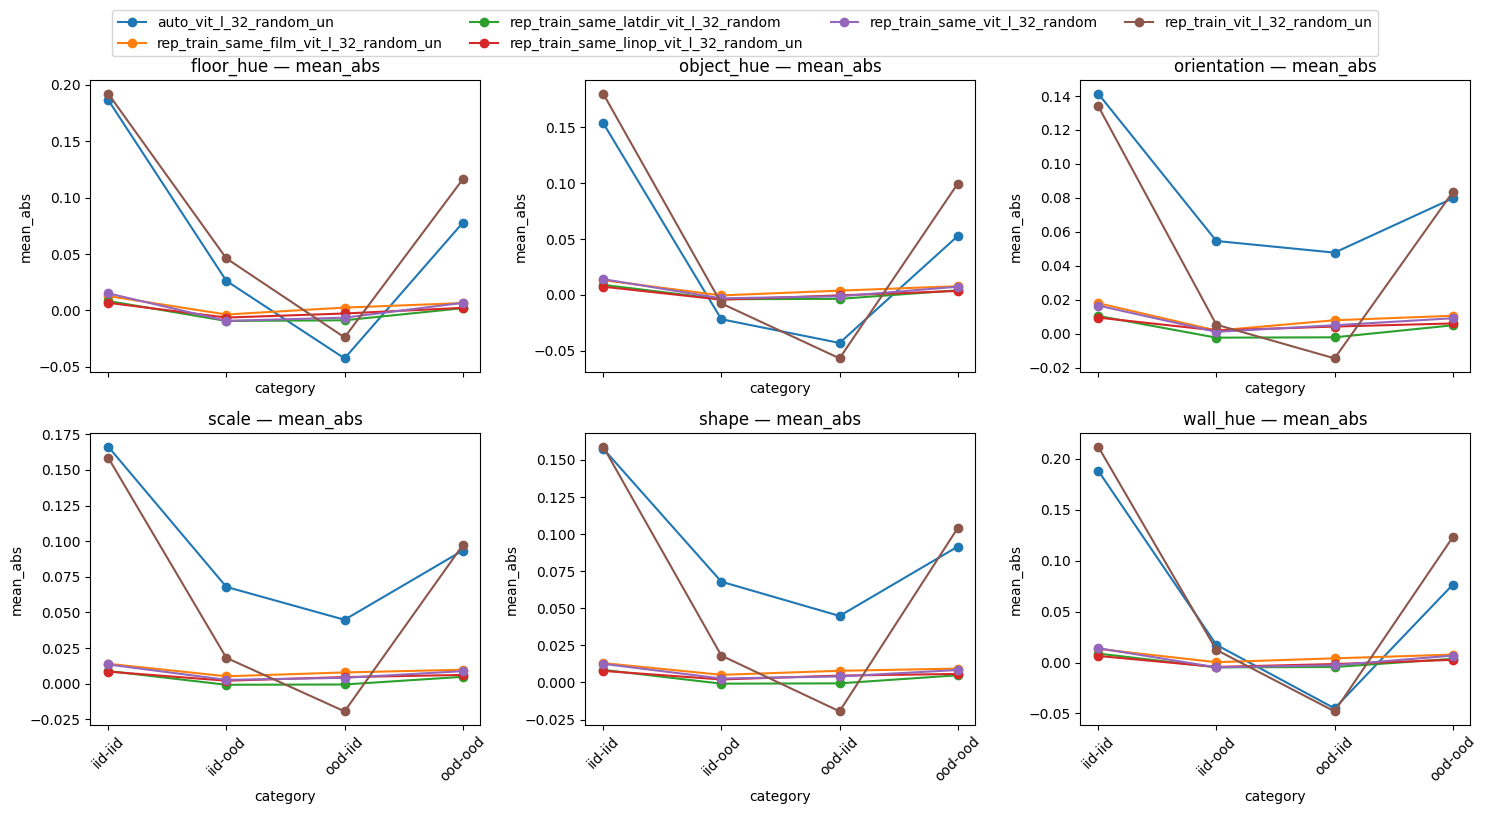

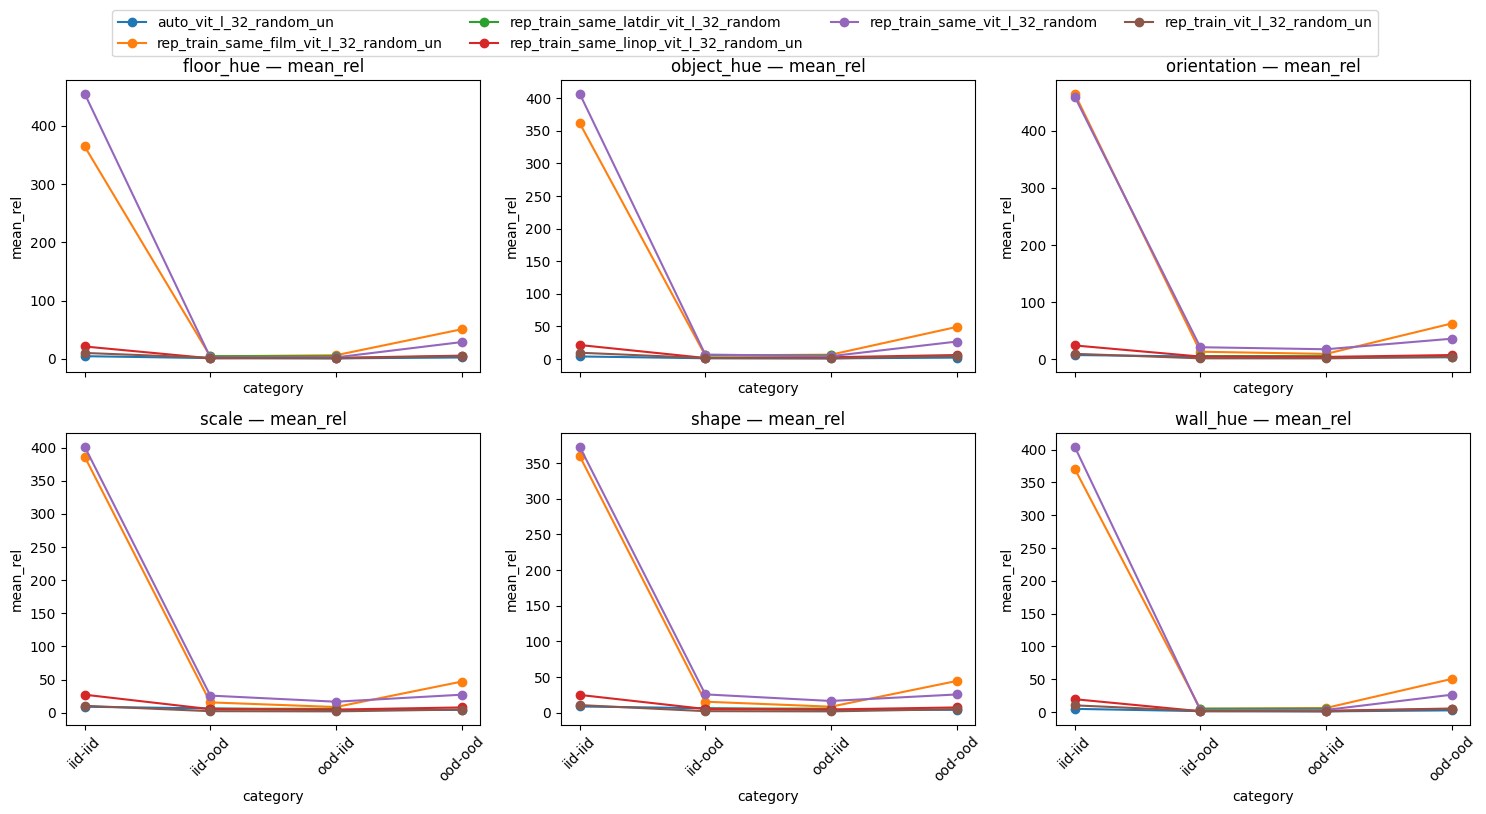

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Elegir métrica a graficar
for metric in ['mean_abs', 'mean_rel']:
    # Orden fijo para las categorías
    ordered_categories = ["iid-iid", "iid-ood", "ood-iid", "ood-ood"]
    grouped['category'] = pd.Categorical(grouped['category'], categories=ordered_categories, ordered=True)
    
    # Obtener heads únicos y modelos
    heads = grouped['head'].unique()
    models = grouped['model'].unique()
    
    # Configurar grilla: ajusta las filas y columnas si hay más heads
    n_heads = len(heads)
    n_cols = 3
    n_rows = int(np.ceil(n_heads / n_cols))
    
    # Crear subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)
    axes = axes.flatten()  # Aplanar para indexar fácilmente
    
    # Graficar cada head en su subplot
    for i, head in enumerate(heads):
        ax = axes[i]
        subset = grouped[grouped['head'] == head]
    
        for model in models:
            data = subset[subset['model'] == model].sort_values('category')
            ax.plot(data['category'], data[metric], marker='o', label=model)
    
        ax.set_title(f"{head} — {metric}")
        ax.set_xlabel("category")
        ax.set_ylabel(metric)
        ax.set_xticks(range(len(ordered_categories)))
        ax.set_xticklabels(ordered_categories, rotation=45)
    
    # Eliminar subplots vacíos si hay
    for j in range(len(heads), len(axes)):
        fig.delaxes(axes[j])
    
    # Solo una leyenda general
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=min(len(models), 4), bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Deja espacio para la leyenda arriba
    plt.show()


## Equivarianza por categoría y delta

In [6]:
grouped = results.groupby(['category', 'model', 'head','delta'])[['abs', 'rel','total']].sum().reset_index()
grouped['mean_rel'] = grouped['rel']/grouped['total']
grouped['mean_abs'] = grouped['abs']/grouped['total']

In [7]:
grouped['mean_rel'].min()

0.19272230406275823

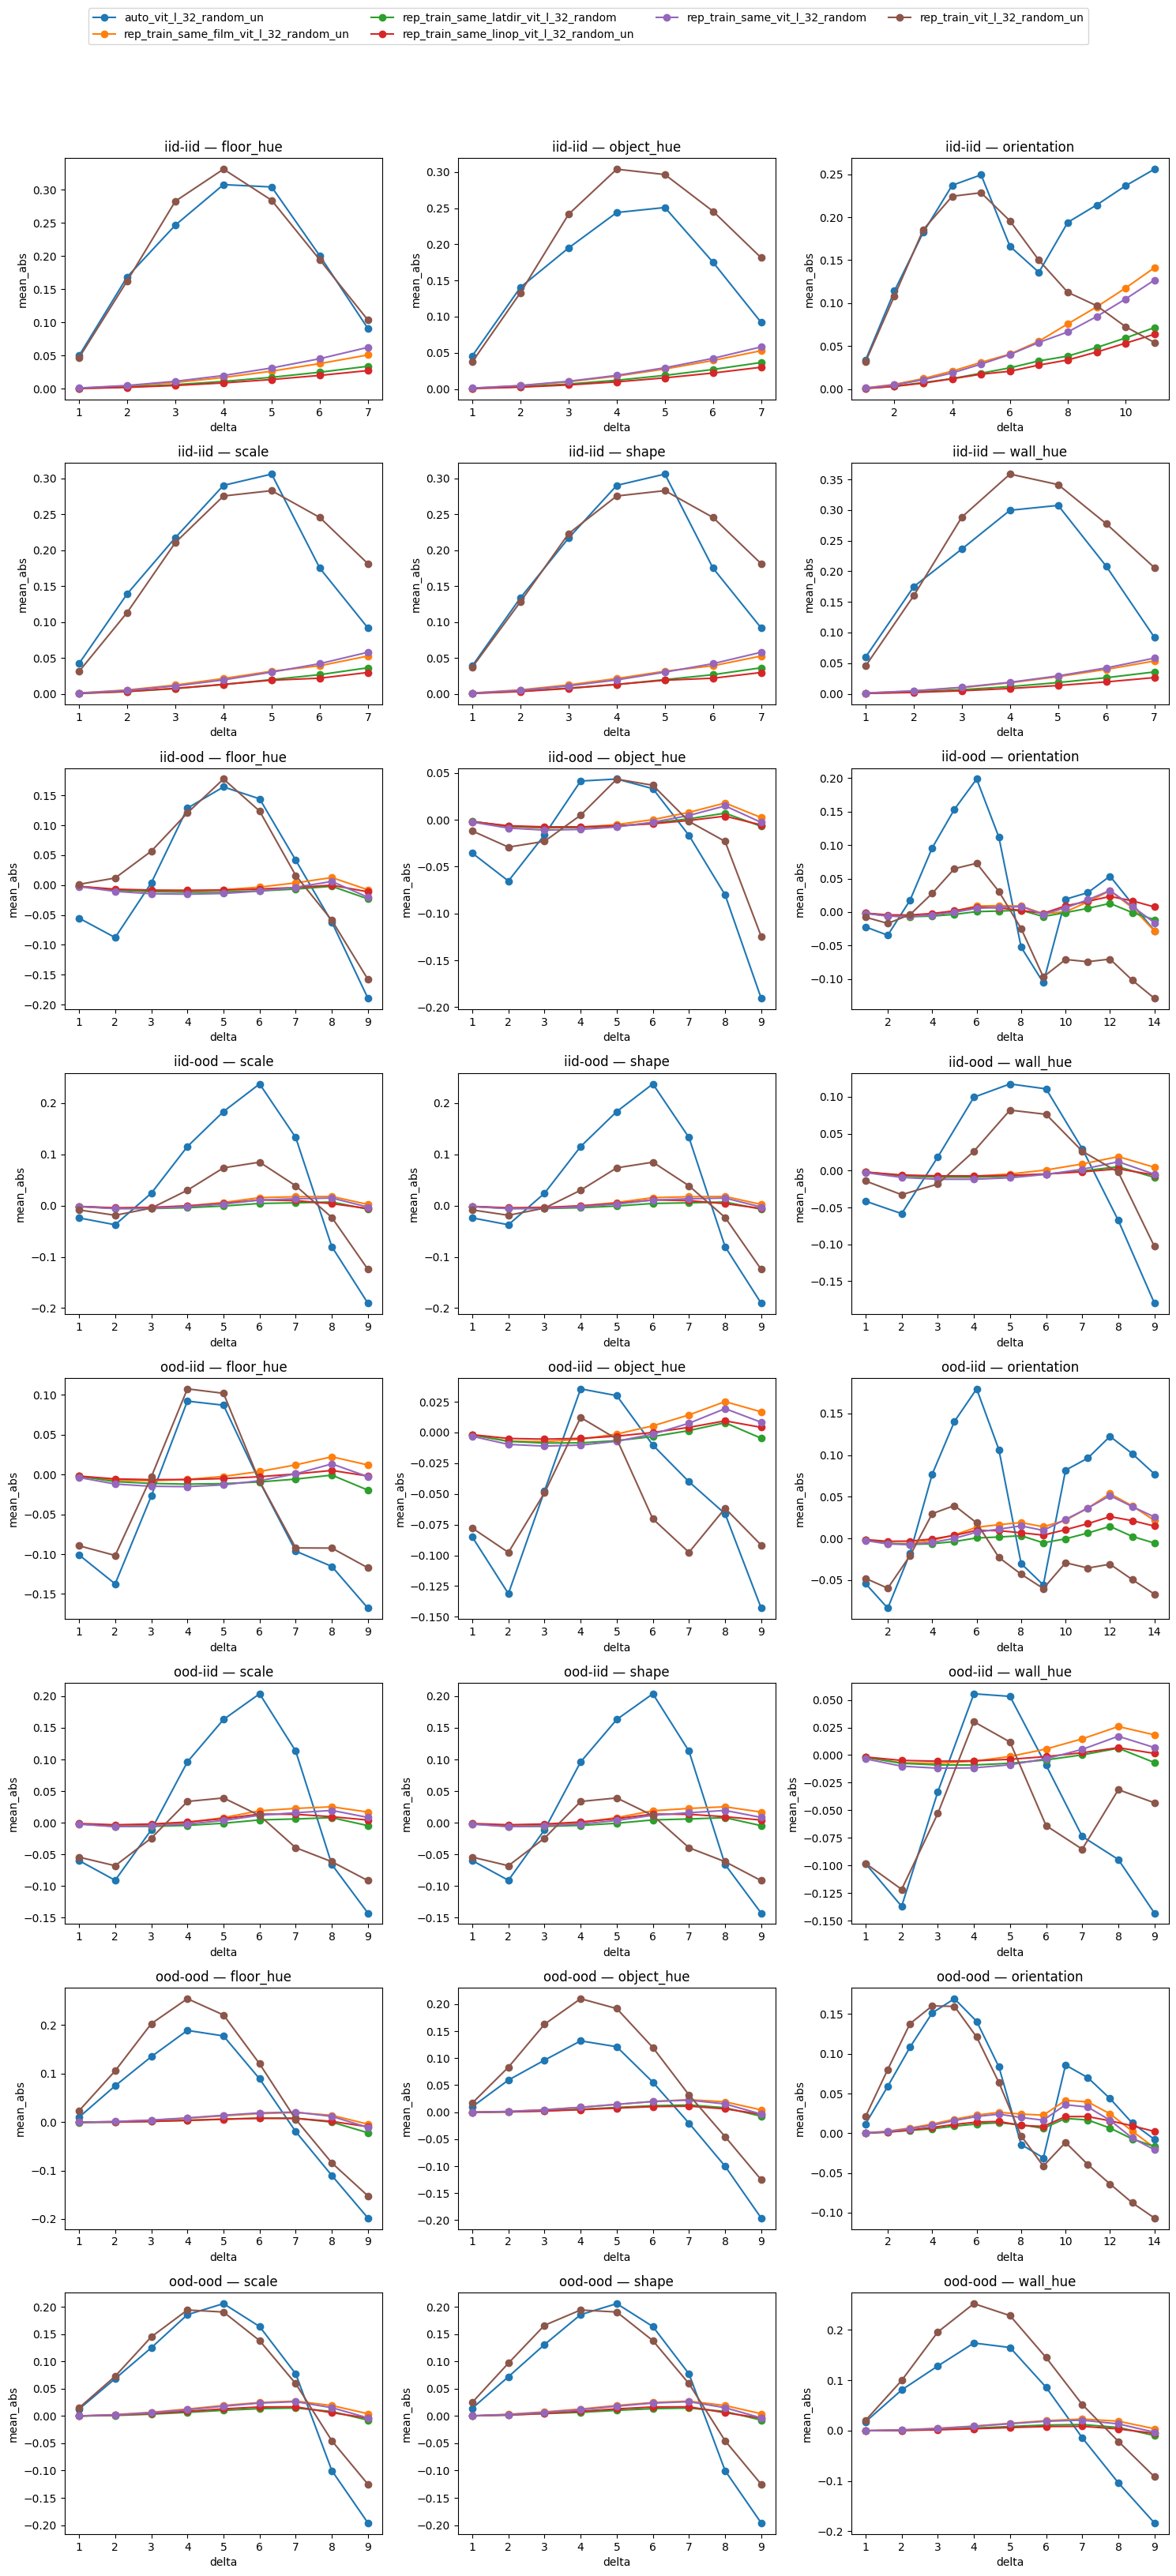

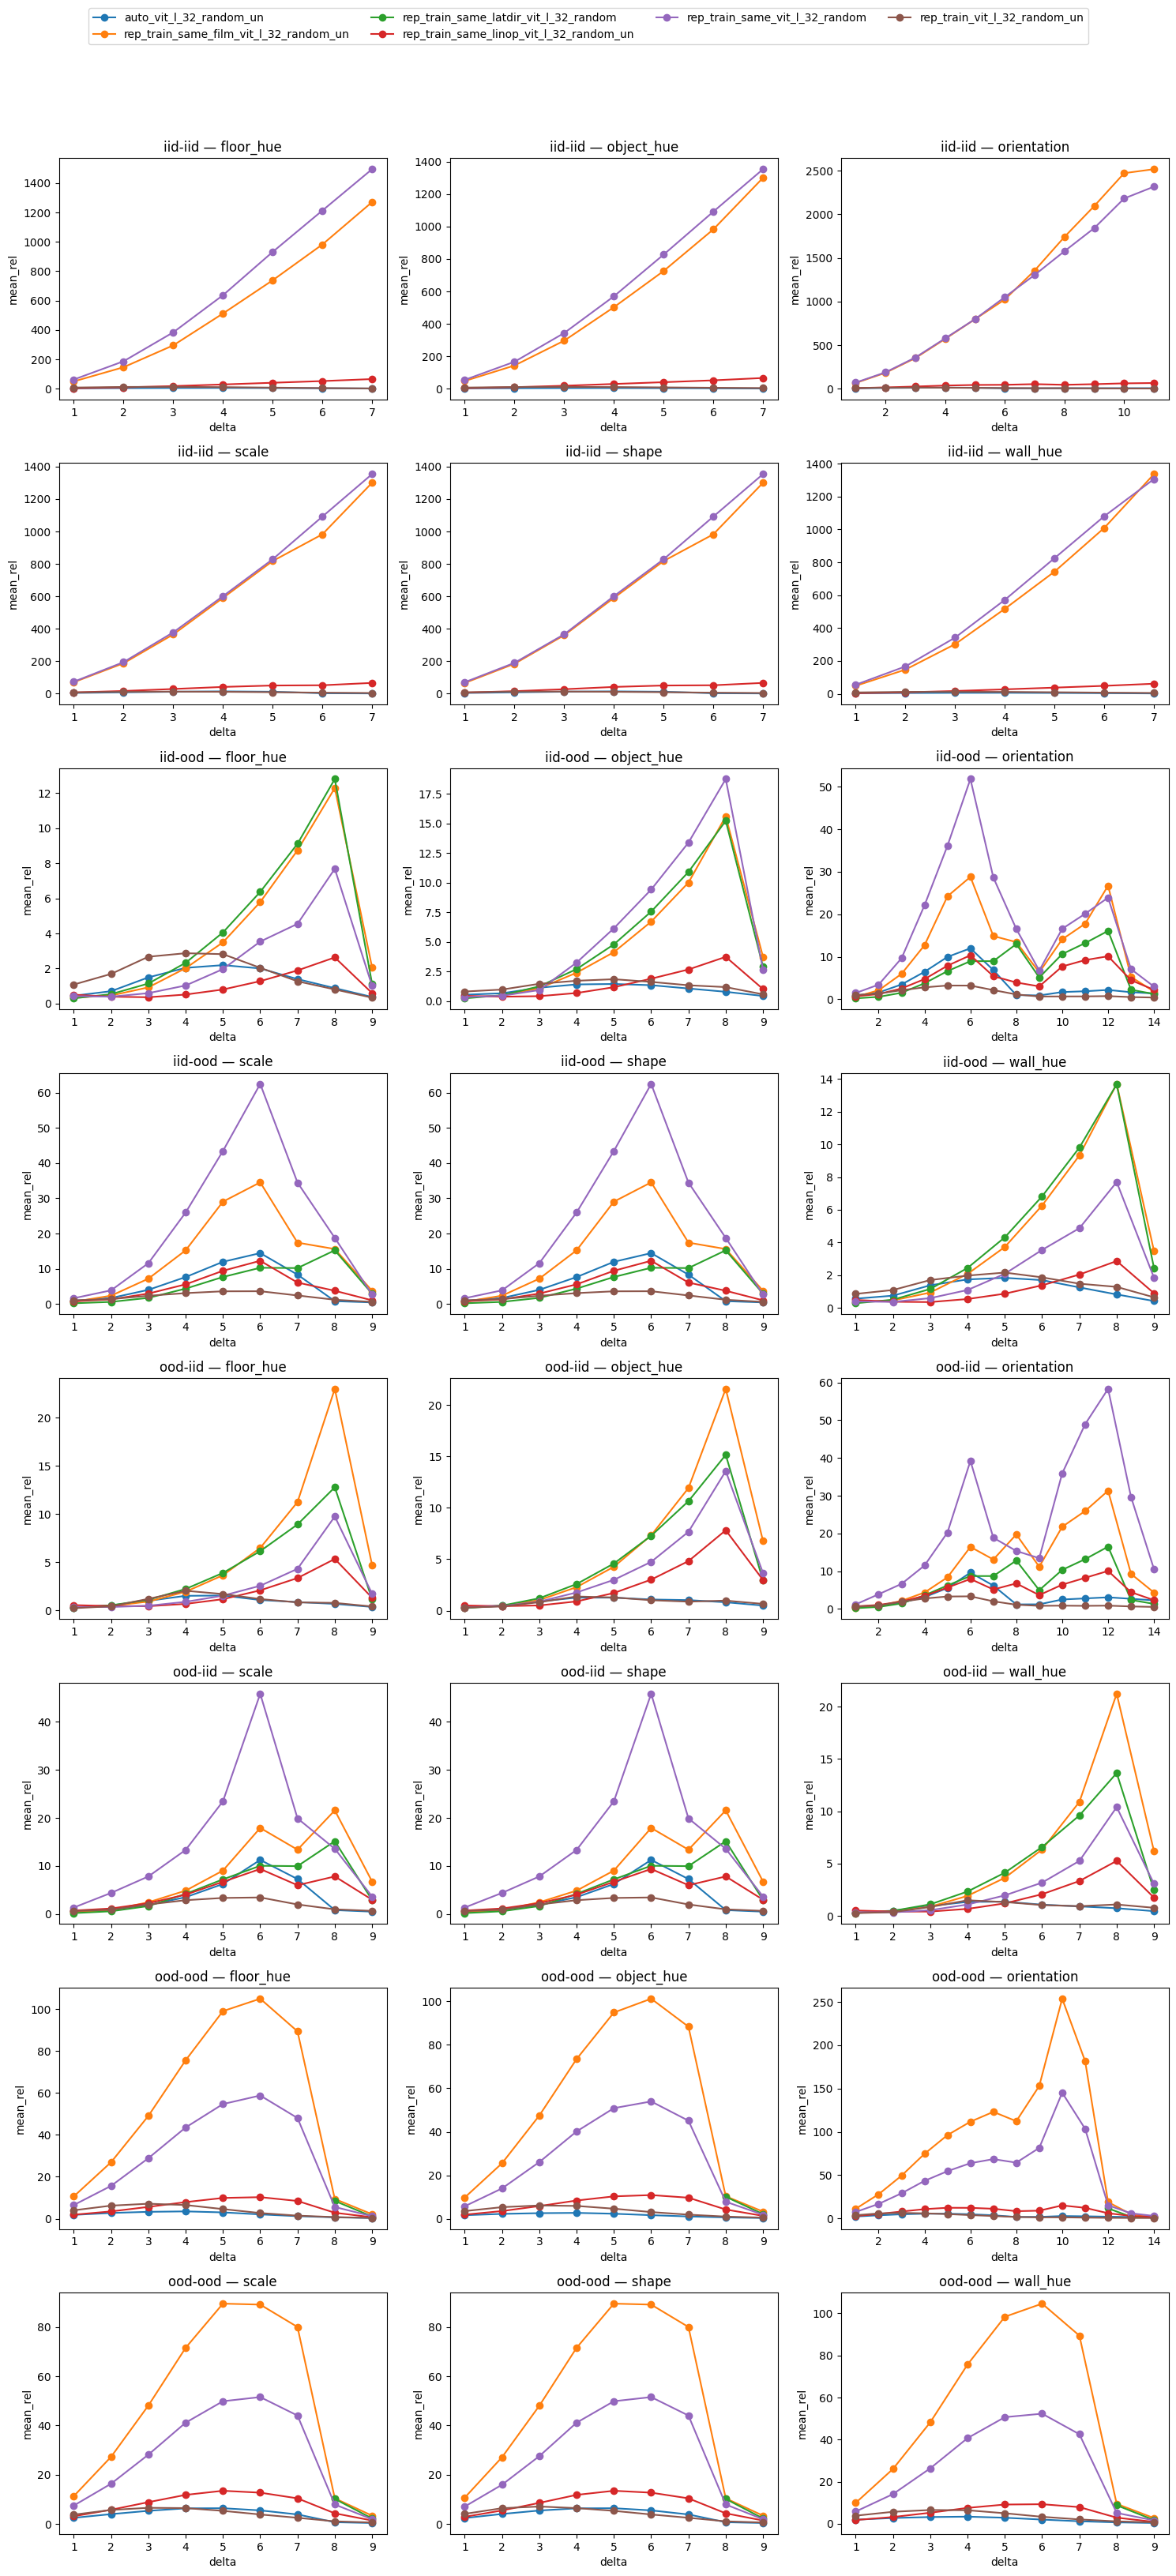

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Elegir la métrica: "mean_rel" o "mean_abs"

for metric in ['mean_abs', 'mean_rel']:
    
    # Obtener todas las combinaciones únicas de (category, head)
    combinations = grouped[['category', 'head']].drop_duplicates().values
    
    # Obtener modelos únicos
    models = grouped['model'].unique()
    
    # Tamaño de la grilla
    n = len(combinations)
    n_cols = 3
    n_rows = int(np.ceil(n / n_cols))
    
    # Crear subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False)
    axes = axes.flatten()
    
    # Iterar por cada combinación
    for i, (cat, head) in enumerate(combinations):
        ax = axes[i]
        
        # Filtrar datos por (category, head)
        subset = grouped[(grouped['category'] == cat) & (grouped['head'] == head)]
    
        # Graficar una curva por modelo
        for model in models:
            data = subset[subset['model'] == model].sort_values('delta')
            if not data.empty:
                ax.plot(data['delta'], data[metric], marker='o', label=model)
    
        ax.set_title(f"{cat} — {head}")
        ax.set_xlabel("delta")
        ax.set_ylabel(metric)
    
    # Eliminar subplots vacíos si hay
    for j in range(len(combinations), len(axes)):
        fig.delaxes(axes[j])
    
    # Leyenda general
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=min(len(models), 4), bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
